<a href="https://colab.research.google.com/github/nilakshgupta/Articles-to-Read/blob/master/Copy_of_04_16_21__of_dog_vision_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

In [ ]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from functools import partial

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

IS_COLAB=0
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

In [ ]:
## Problem
#Identifying the breed of a dog given an image of a dog.

## Data Source: Kaggle competition
#https://www.kaggle.com/c/dog-breed-identification

In [ ]:
## Unzipping the uploade data into Google Drive
#!unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

In [ ]:
import tensorflow as tf
print("TF version", tf.__version__)
import tensorflow_hub as hub
print("TF Hub version", hub.__version__)


TF version 2.4.1
TF Hub version 0.11.0


#Data Exploration and pre-processing



In [ ]:
import pandas as pd
labels_csv= pd.read_csv('/content/drive/MyDrive/Dog Vision/labels.csv')
print(labels_csv.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


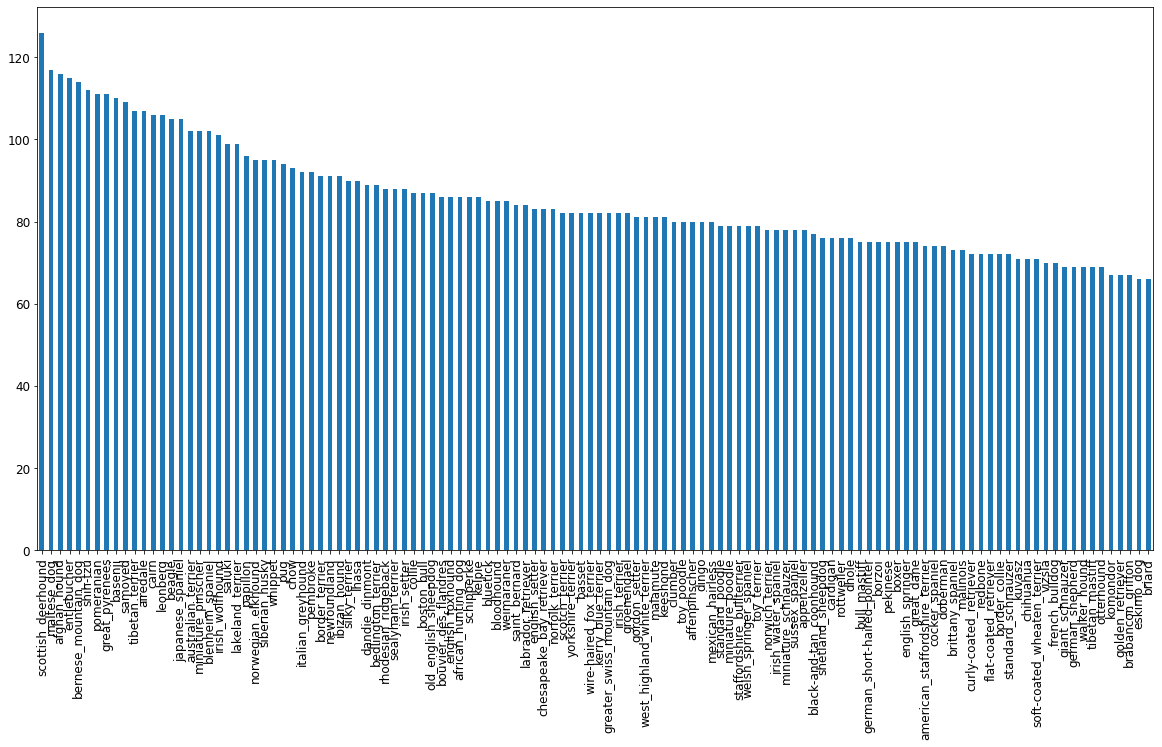

In [ ]:
labels_csv.breed.value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv.breed.value_counts(normalize=True)

scottish_deerhound      0.012326
maltese_dog             0.011446
afghan_hound            0.011348
entlebucher             0.011250
bernese_mountain_dog    0.011152
                          ...   
komondor                0.006554
golden_retriever        0.006554
brabancon_griffon       0.006554
eskimo_dog              0.006457
briard                  0.006457
Name: breed, Length: 120, dtype: float64

In [ ]:
labels_csv.breed.value_counts().median()

82.0

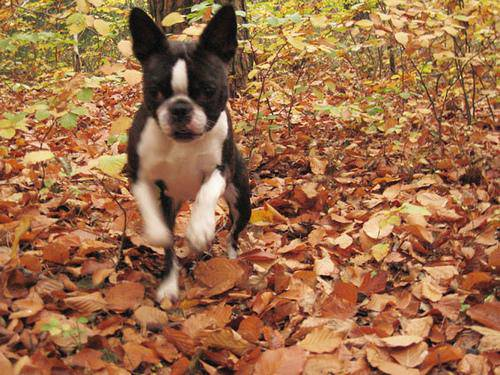

In [ ]:
# Preparing the Images
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:
#Creating a list of filepath to images and appending .jpg file extension to all the file names in the training set
filenames=["drive/MyDrive/Dog Vision/train/" + fname + '.jpg' for fname in labels_csv['id']]
filenames[:2]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg']

In [ ]:
# Extra check to see that no. of files are same
print(len(os.listdir("drive/MyDrive/Dog Vision/train")))
print(len(filenames))

10222
10222


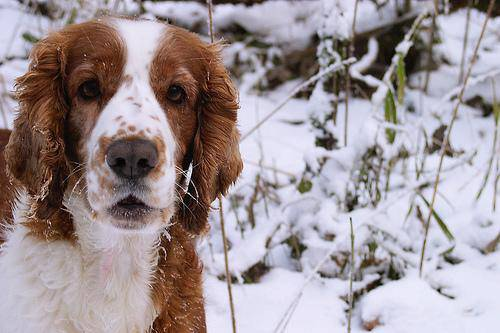

In [ ]:
# Image from file path
Image(filenames[2100])

In [ ]:
# Turning labels into boolean array
labels=labels_csv.breed.to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# Find unique values
unique_breeds= np.unique(labels)
len(unique_breeds)

120

In [ ]:
boolean_labels = [labels == unique_breeds for labels in labels]
print(labels[0])   
print(np.where(unique_breeds==labels[0]))    #index where labels occurs.
print(boolean_labels[0].argmax())     #index where label occurs in boolean array
print(boolean_labels[0].astype(int))   #there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
# setup x and y variables.
X = filenames
y = boolean_labels

In [ ]:
# Set number of images to use for initial run and using scikit learn for splitting the dataset
NUM_IMAGES = 1000 
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)


(800, 800, 200, 200)

In [ ]:
# Check out the training data (image file paths and labels)
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

In [ ]:
# Convering images to tensors
IMG_SIZE = 224

def process_image(image_path):
  
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [ ]:
process_image(tf.constant(X_train[2]))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.62352943, 0.6117647 , 0.5921569 ],
        [0.627451  , 0.6156863 , 0.59607846],
        [0.6316877 , 0.619923  , 0.60031515],
        ...,
        [0.5254902 , 0.50980395, 0.49803925],
        [0.5254902 , 0.50980395, 0.49803925],
        [0.5254902 , 0.50980395, 0.49803925]],

       [[0.62352943, 0.6117647 , 0.5921569 ],
        [0.627451  , 0.6156863 , 0.59607846],
        [0.6316877 , 0.619923  , 0.60031515],
        ...,
        [0.5294118 , 0.5137255 , 0.5019608 ],
        [0.5254902 , 0.50980395, 0.49803925],
        [0.5254902 , 0.50980395, 0.49803925]],

       [[0.62352943, 0.6117647 , 0.5921569 ],
        [0.627451  , 0.6156863 , 0.59607846],
        [0.6316877 , 0.619923  , 0.60031515],
        ...,
        [0.5320991 , 0.51641285, 0.50464815],
        [0.5254902 , 0.50980395, 0.49803925],
        [0.5254902 , 0.50980395, 0.49803925]],

       ...,

       [[0.4693539 , 0.2794472 , 0.18925112],
        [0.45

In [ ]:
# Create a simple function to return a tuple (image, label), this will be useful for creating batches
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [ ]:
get_image_label(tf.constant(X_train[2]), y_train[2])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.62352943, 0.6117647 , 0.5921569 ],
         [0.627451  , 0.6156863 , 0.59607846],
         [0.6316877 , 0.619923  , 0.60031515],
         ...,
         [0.5254902 , 0.50980395, 0.49803925],
         [0.5254902 , 0.50980395, 0.49803925],
         [0.5254902 , 0.50980395, 0.49803925]],
 
        [[0.62352943, 0.6117647 , 0.5921569 ],
         [0.627451  , 0.6156863 , 0.59607846],
         [0.6316877 , 0.619923  , 0.60031515],
         ...,
         [0.5294118 , 0.5137255 , 0.5019608 ],
         [0.5254902 , 0.50980395, 0.49803925],
         [0.5254902 , 0.50980395, 0.49803925]],
 
        [[0.62352943, 0.6117647 , 0.5921569 ],
         [0.627451  , 0.6156863 , 0.59607846],
         [0.6316877 , 0.619923  , 0.60031515],
         ...,
         [0.5320991 , 0.51641285, 0.50464815],
         [0.5254902 , 0.50980395, 0.49803925],
         [0.5254902 , 0.50980395, 0.49803925]],
 
        ...,
 
        [[0.4693539 , 0.2794472 